<a href="https://colab.research.google.com/github/kitadahiko/etc/blob/master/!!Stable_Diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title GPUとRAMの確認用
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [1]:
#@title Stable Diffusion学習済みモデル指定とパイプライン
!pip install diffusers transformers accelerate scipy safetensors

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# model_id = "Linaqruf/anything-v3.0"
# model_id = "Linaqruf/hitokomoru-diffusion-v2"
# model_id = "hakurei/waifu-diffusion"
# model_id = "aipicasso/cool-japan-diffusion-2-1-0-beta"
# model_id = "naclbit/trinart_stable_diffusion_v2"
# model_id = "naclbit/trinart_characters_19.2m_stable_diffusion_v1"
# model_id = "andite/anything-v4.0"
# model_id = "andite/pastel-mix"
# model_id = "eimiss/EimisAnimeDiffusion_1.0v"
# model_id = "gsdf/Counterfeit-V2.5"
model_id = "andite/anything-v4.0" #@param {type:"string"}

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# safety_checker=None→NSFW（R18表現）でも出力（？）
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.9 MB/s eta 0:00:00


safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

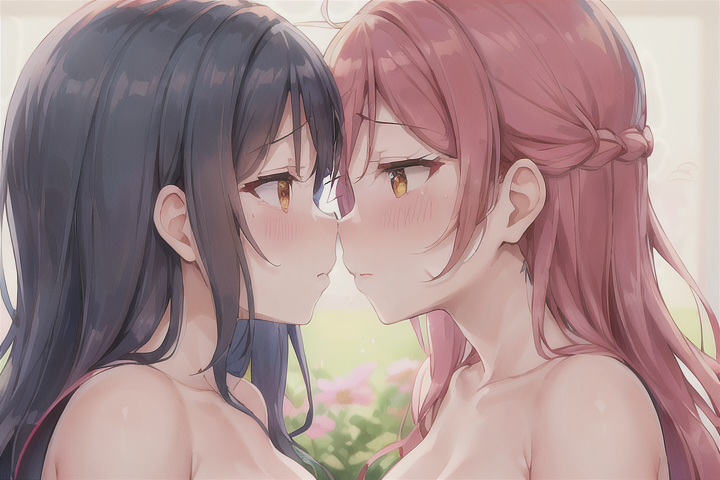

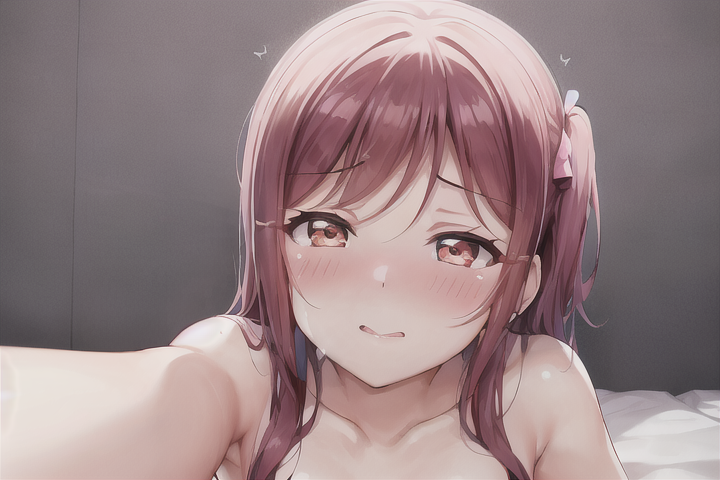

In [5]:
#@title 画像生成（メモ：promptは前から優先／()で強め／[]で弱め／重み付けを数値指定可）
# CUDA out of memoryエラーに意味ある？https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
torch.cuda.empty_cache()

g_cuda = None

# seed setting 元は52362→シードをランダム可に（とりあえずintの範囲で）
import random
g_cuda = torch.Generator(device='cuda')
is_random_seed = True #@param {type:"boolean"}
if is_random_seed:
    seed = random.randint(0,65535)
else:
    seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

# prompt = "masterpiece, best quality, high quality, 1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress"
# negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"
p1 = "(((Love Live! Sakurauchi Riko))), 2 girls eye to eye kiss, unclothed, sexual embarassing face" #@param {type:"string"}
p2 = "[[[flowers]]], [[[clear sky]]], blush" #@param {type:"string"}
p3 = "masterpiece, best quality, high quality, extremely detailed beautiful face, authentic body" #@param {type:"string"}
prompt =  p1 + ", " + p2 + ", " + p3
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

# inference_mode文書：Code run under this mode gets better performance by disabling view tracking and version counter bumps
# https://pytorch.org/docs/stable/generated/torch.inference_mode.html
with autocast("cuda"), torch.inference_mode():
    images = pipe(prompt, 
                 negative_prompt=negative_prompt, 
                 width=720,
                 height=480,
                 guidance_scale=12,
                 num_images_per_prompt=2,
                 generator=g_cuda,
                 num_inference_steps=50).images

import datetime
for i, img in enumerate(images):
    filename = datetime.datetime.now().strftime('%Y%m%d%H%M%S') + "_" + model_id[model_id.rfind("/")+1:] + "_" + prompt + "_s" + str(seed).zfill(5) + "_" + str(i) + ".jpg"
    if len(filename)>250:
        filename = datetime.datetime.now().strftime('%Y%m%d%H%M%S') + "_" + model_id[model_id.rfind("/")+1:] + "_" + p1 + ", " + p2 + "_s" + str(seed).zfill(5) + "_" + str(i) + ".jpg"
    img.save(filename)
    display(img)

In [ ]:
#@title Zipでダウンロード
# outputフォルダをZipファイルにしてダウンロード
# https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab
!zip -r /outputs.zip /content/
from google.colab import files
files.download("/outputs.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.02.09/ (stored 0%)
  adding: content/.config/logs/2023.02.09/14.41.25.066138.log (deflated 86%)
  adding: content/.config/logs/2023.02.09/14.41.57.827027.log (deflated 57%)
  adding: content/.config/logs/2023.02.09/14.41.58.569347.log (deflated 56%)
  adding: content/.config/logs/2023.02.09/14.41.32.920046.log (deflated 58%)
  adding: content/.config/logs/2023.02.09/14.41.00.912134.l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>